## Closed-Loop Steering of unicycle-like robot based on Lyapunov framework approach

william.martins@ee.ufcg.edu.br
28/02/2023

In [4]:
from scipy.integrate import solve_ivp, trapezoid, cumulative_trapezoid

import numpy as np
from numpy import cos, sin, array, pi, arctan
from matplotlib import pyplot as plt
from animate_robot import RobotAnimation
# from plot_result import plot_sim

### Unicycle robot parking problem

![](figures/diagrams/body_target_frame.png)

From the figure, the robot's Kinematic Equations could be defined in target frame \<g\> as:

\begin{equation}
\begin{matrix}
\dot{x} = u\cos{\phi} \\
\dot{y} = u\sin{\phi} \\
\dot{\phi} = w
\end{matrix}
\end{equation}


In polar coordinates, in terms of error distance and angular orientations, where distance error is
$
e = g_{pos} - r_{pos} = -r_{pos}
$. So the robot pose could be bring to goal frame by using the rotation matrix
$$e = -[x\cos(\theta) + y\sin(\theta)]$$
It's first derivative gives
$$\dot{e} = -[u\cos(\theta)\cos(\phi) + u\sin(\theta)\sin(\phi)] = -u\cos(\theta - \phi)$$
Also, the unicycle robot is a non-holomonic system it's restricted to forwarding movements

$$
we - u\sin(\alpha) = 0 \rightarrow \dot{\theta} = \frac{u}{e}\sin(\alpha)    
$$


The robot orientation error related to target is $\alpha = \theta - \phi$, it's first derivative is

$$
\begin{equation}
\dot{\alpha} = \frac{u}{e}\sin(\alpha) - w
\end{equation}
$$

### Lyapunov Approach

The candidate Lyapunov function is a quadratic form like:
$$
V_1 = \frac{1}{2}\lambda e^2 \\
V_2 = \frac{1}{2}(\alpha^2 + h\theta^2) \\
V = V_1 + V_2
$$

The Lyapunov stability theorem grant a way to find a stable controller that brings the error to zero that is obtained from Lyapunov candidate function.

$$\dot{V_1} = e\dot{e} = -\lambda u\cos(\alpha)e$$

for first term of Lyapunov decrease over time, u could be defined so that makes $\dot{V_1} \le 0$
$$ u = \gamma\cos(\alpha)e$$ 

$$\dot{V_1} = -\lambda u\cos(\alpha)^2e^2 \le 0$$

Similarity, for second term of Lyapunov Function, and using the kinematic equation for $\dot{\alpha}$ and $\dot{\theta}$:
$$
\dot{V_2} = \alpha\dot{\alpha} + h\theta\dot{\theta} = \alpha[-w + \frac{u}{e\alpha}(\alpha + h\theta)\sin(\alpha)] \le 0
$$

so, solving for w
$$ w = k\alpha + \frac{\gamma}{e}\cos\alpha\sin\alpha(\alpha+h\theta) \\
\dot{V_2} = -k\alpha^2 \le 0
$$

So using the relation of u, w that satisfy the Lyapunov Theorem in kinematic equations, we have the closed control law for steering robot to goal

$$
\dot{e} = -u\cos(\alpha) = -(\gamma\cos^2\alpha)e \\
\dot{\alpha} = \frac{u}{e}\sin(alpha) - w = -k\alpha - \frac{\gamma h\theta}{\alpha}\cos\alpha\sin\alpha \\
\dot{\theta} = \frac{u}{e}\sin(\alpha) = \gamma\cos\alpha\sin\alpha
$$

Solving the state equations, it's possible to obtain the robot poses in respect of the current frame by the trigonometric relations:

\begin{matrix}
x = -e\cos\theta \\
y = -e\sin\theta
\end{matrix}

In [5]:
def coord2states(pose):
    x, y, phi = pose
    e = (x**2 + y**2)**.5 # considering target on origin
    theta = arctan(y / x)
    alpha = theta - phi
    return [e, alpha, theta]

def states2pose(states):
    """
        Obtains the coord of robot based in it's location on
        target frame
     """
    e, alpha, theta = states
    x = -e*cos(theta)
    y = -e*sin(theta)
    phi = theta-alpha
    return x, y, phi

def drive_steering(t, prev_state, gamma, h, k):
    "Implements Closed-Loop Control Law Equations"

    e, alpha, theta = prev_state
    # system states
    dalpha = -k*alpha - (h*theta*gamma)/alpha*cos(alpha)*sin(alpha)
    dtheta = gamma*cos(alpha)*sin(alpha)
    # system output
    de = -e*gamma*cos(alpha)**2
    # u = gamma*cos(alpha)*e
    u = dtheta*e/sin(alpha)
    return array([de, dalpha, dtheta])

## Linearization

Around the equilibrium point [0, 0 $\theta$], the system has derivative, so, it's possible to obtain a linearized form of the control law.

around equilibrium point the error is
$ \dot{e} = -(\gamma\cos^2\alpha)e \rightarrow -\gamma e$

the rotation could be expressed

$ \dot{\theta} = \gamma\alpha$


$\dot{\alpha} = -k\alpha - \frac{\gamma h\theta}{\alpha}\cos\alpha\sin\alpha \rightarrow -k\alpha - \gamma h\theta$

![](figures/diagrams/ )

In [6]:
def linear_drive_steering(t, prev_state, gamma, h, k):
    "Implements Linearization of Robot Steering Control Law"
    e, alpha, theta = prev_state
    de = -gamma*e
    dalpha = -k*alpha - gamma*h*theta
    dtheta = gamma*alpha
    u = gamma*e
    return array([de, dalpha, dtheta])

def system_poles(gamma, h, k):
    # implements a conditional check about solution stability
    # and return system poles
    
    # assert(h > 1, "h must be greater than 1")
    # assert(k > 2*gamma, "k must be greater than 2*gamma = " + str(2*gamma))
    # assert(k < gamma*(h+1), "k must be lesser than gamma(h+1) = " + str(gamma*(h+1)))
    wd = np.sqrt(k**2 - 4*h*gamma**2)
    lambda1 = -k/2 + wd/2
    lambda2 = -k/2 - wd/2
    return lambda1, lambda2


In [7]:
def plot_sim(sol):
    t = sol.t
    states = sol.y
    dt = t[1]-t[0]

    e = states[0]
    alpha = states[1]
    theta = states[2]

    # alpha = cumulative_trapezoid(dalpha, t)
    x, y, phi = states2pose(states=states)

    de = [ (e[i] - e[i-1])/dt for i in range(1, len(t))]
    de = [0] + de
    print(len(de), len(t))
    u = -array(de)/cos(alpha)
    # x, y = states2pose(t, states, initial_pose)
    print('(x0, y0, phi) =', x[0], y[0], phi[0])

    plt.figure()
    ax = plt.subplot(3, 2, 2)
    ax.plot(t, e)
    ax.set_title("Robot steering error")
    ax.set_ylabel("e(t)")

    ax = plt.subplot(3, 2, 6)
    ax.plot(t, theta*180/pi, t, alpha*180/pi)
    ax.set_title("Trajectory orientation")
    ax.set_ylabel("$\\theta(t), \\alpha$ deg")
    ax.set_xlabel("$t (s) $")
    ax.legend(['$\\theta(t)$', '\\alpha'])

    ax = plt.subplot(3, 2, 4)
    ax.plot(u)
    ax.set_title("Linear velocity")
    ax.set_ylabel("$\\alpha(t) deg$")
    ax.set_xlabel("$t (s) $")

    ax = plt.subplot(3, 2, 1)
    ax.set_title("Robot x-pose over time")
    ax.plot(t, x)
    ax.set_ylabel("$x(t)$")
   
    ax = plt.subplot(3, 2, 3)
    # ax.plot(t, sol.y[2])
    ax.plot(t, y)
    ax.set_title("Robot y-pose over time")
    ax.set_ylabel("$y(t)$")
    ax.set_xlabel("t (s)")

    ax = plt.subplot(3, 2, 5)
    plt.plot(x, y)
    plt.title('Robot Trajectory')
    plt.xlabel('x')
    plt.ylabel('y')

    [plt.subplot(3,2,i).grid(True) for i in range(1, 7)]
    plt.grid(True)
    plt.subplots_adjust(hspace=0.45)  # Adjust the value as needed
    
    # plt.figure()
    # Plot the initial and final robot position
    pose = array([x, y, phi]).T
    print(pose.shape)
    # robot_anim = RobotAnimation(x[0], y[0], phi[0], pose, 
    #                             goal=array([0, 0]), 
    #                             title="Closed-Loop Sterring control of unicycle-like robot")
    
    plt.show()
    # saving to m4 using ffmpeg writer 
    # robot_anim.save_gif('robot_animation.gif', fps=10)

## Simulation

Dominant pole = -1.2679491924311228
100 100
(x0, y0, phi) = -1.0000000000000002 1.0000000000000002 2.356194490192345
(100, 3)


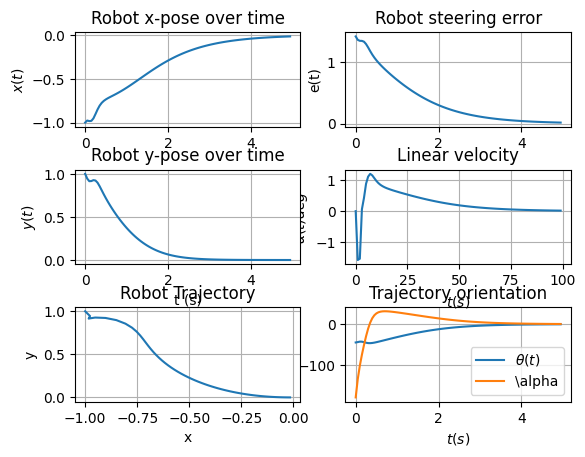

In [8]:

initial_state = [1*np.sqrt(2), -pi, -pi/4]

# Closed Loop parameters
gamma = 1
h = 6
k = 6

l1, l2 = system_poles(gamma, h, k)
sigma = max(l1, l2)          
print('Dominant pole =', sigma)

dt = 50e-3
t = np.arange(0, 5, dt)

sol = solve_ivp(fun = drive_steering, t_span=[t[0], t[-1]], y0=initial_state, t_eval=t,
                method='RK45',  # Runge-Kutta
                args=[gamma, h, k]
)

x, y, phi = states2pose(states=sol.y)
pose = array([x, y, phi]).T

# sol = odeint(drive_steering, initial_state, t)

# print(sol.y[2])
plot_sim(sol)

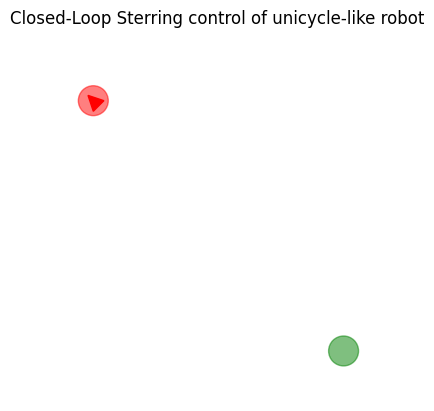

In [36]:
robot_anim = RobotAnimation(x[0], y[0], phi[0], pose, 
                                goal=array([0, 0]), 
                                title="Closed-Loop Sterring control of unicycle-like robot")
from IPython.display import HTML
HTML(robot_anim.animation.to_jshtml())

## Simulation of linearized control law

100 100
(x0, y0, phi) = -5.000000000000001 5.000000000000001 2.356194490192345
(100, 3)


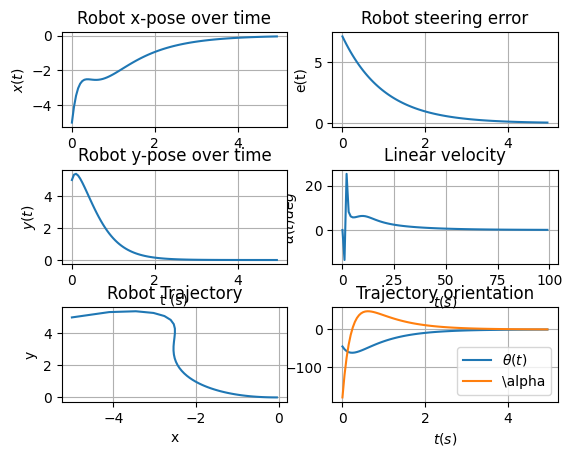

In [31]:
sol = solve_ivp(fun = linear_drive_steering, t_span=[t[0], t[-1]], y0=initial_state, t_eval=t,
                method='RK45',  # Runge-Kutta
                args=[gamma, h, k]
)

x, y, phi = states2pose(states=sol.y)
pose = array([x, y, phi]).T

plot_sim(sol)